# Results with GPR and experimental uncertainties

This workbook propagates the uncertainties from experimental repeats and GPR model variance into the final ternary compositions.

In [251]:
# import packages
import os, sys, platform
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt
from matplotlib import gridspec

print('Python version', sys.version)
print('Running on', platform.system())

# colours (From Birmingham With Love)
jade = np.array([0, .66, .436]) # statue green
blue = np.array([.057, .156, .520]) # hey there mr blue
brown = np.array([.515, .158, .033]) # did someone order CDM?
red = np.array([.85, .20, 0]) # tikka masala
gold = np.array([1, .67, .14]) # Staffordshire hoard
claret = np.array([.429, .073, .238]) # claret
grey = np.array([.585, .612, .675]) # library grey
black = np.array([0,0,0]) # this is a black

Python version 3.10.2 (v3.10.2:a58ebcc701, Jan 13 2022, 14:50:16) [Clang 13.0.0 (clang-1300.0.29.30)]
Running on Darwin


---
## Averaging uncertainties

* $\sigma_\text{exp}$: Standard deviation from across the repeated Hittorf experiment measurements
* $\sigma_\text{GPR}$: Standard deviation from GPR model used to infer the composition

Combined uncertainty is then given by:

$$ \sigma = \sqrt{\sigma_\text{exp}^2 + \sigma_\text{GPR}^2} $$

In [249]:
#Define a function that combines uncertainties and adds/subtracts to the ternary dataset
#==========================================================================================
def combine_uncertainties(results_path):
    #Results file
    df = pd.read_csv (results_path)
    df = df[(df.side == 'anodic') | (df.side == 'cathodic')]

    #GPR standard deviations
    sd_gpr = np.mean(df.stdev)*np.array([1,1,1]) #For each species

    #Experimental standard deviations
    anodic = df[df.side == 'anodic'][['xLi','xEMC','xEC']].to_numpy()
    x_anodic = np.mean(anodic,0) #mean
    sd_exp_anodic = np.std(anodic,0)

    cathodic = df[df.side == 'cathodic'][['xLi','xEMC','xEC']].to_numpy()
    x_cathodic = np.mean(cathodic,0) #mean
    sd_exp_cathodic = np.std(cathodic,0)

    #Combining the two sources of uncertainty:
    sd_anodic = np.sqrt(sd_gpr**2 + sd_exp_anodic**2)
    sd_cathodic = np.sqrt(sd_gpr**2 + sd_exp_cathodic**2)

    #Each average ternary point needs to have uncertainty included in 6 directions 
    from itertools import permutations
    def unique_permutations(iterable, r=None):
        previous = tuple()
        for p in permutations(sorted(iterable), r):
            if p > previous:
                previous = p
                yield p
    #2 groups for anodic and cathodic compositions where you +err and -1/2 err to the other 2
    perm = np.array(list(unique_permutations([1, -0.5, -0.5])))
    perm = np.append(perm,perm*-1,0)
    perm = np.tile(perm,(2,1))

    x_array = np.vstack((np.tile(x_anodic,(6,1)), np.tile(x_cathodic,(6,1))))  #Tile average ternary compositions
    sd_array = np.vstack((np.tile(sd_anodic,(6,1)), np.tile(sd_cathodic,(6,1)))) #Tile standard deviations

    x_with_uncertainties = x_array + (sd_array*perm)
    
    return x_with_uncertainties
  

In [240]:
#Apply the uncertainties to each composition tested, and output arrays with uncertainties included
#==========================================================================================

# Processing 55050
results_path = 'results/Result_Summary_55050.csv'
x1 = combine_uncertainties(results_path)

# Processing 55100
results_path = 'results/Result_Summary_55100.csv'
x2 = combine_uncertainties(results_path)

# Processing 55150
results_path = 'results/Result_Summary_55150.csv'
x3= combine_uncertainties(results_path)

#Stack all points together
x_data = np.vstack((x1,x2,x3))

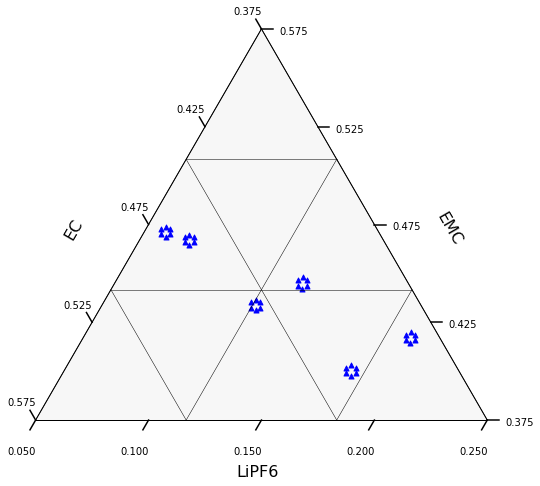

In [252]:
#Plot the polarized ternary compositions
#==========================================================================================

import ternary

fig = ternary.plt.figure(figsize=(15, 8))
ax = fig.add_subplot(2, 1, 2)

tax = ternary.TernaryAxesSubplot(ax=ax,scale=30)
axes_colors = {'b': 'k', 'r': 'k', 'l': 'k'}
tax.boundary(linewidth=1.0, axes_colors=axes_colors)
tax.gridlines(color="k", multiple=10, linewidth=0.5, ls='-')
tax.ax.axis("equal")
tax.ax.axis("off")

fontsize = 16
# tax.set_title("Zoomed region",color='r')
tax.left_axis_label("EC", fontsize=fontsize, offset=0.17, color='k')
tax.right_axis_label("EMC", fontsize=fontsize, offset=0.17, color='k')
tax.bottom_axis_label("LiPF6", fontsize=fontsize, offset=0.03, color='k')

tax.set_axis_limits({'b': [0.05, 0.25], 'l': [0.375, 0.575], 'r': [0.375, 0.575]})
tax.get_ticks_from_axis_limits(multiple=7)
tick_formats = "%.3f"
tax.set_custom_ticks(fontsize=10, offset=0.025, multiple=5,
                      axes_colors=axes_colors, tick_formats=tick_formats)

# plot some data
points = x_data
points_c = tax.convert_coordinates(points, axisorder='blr')
tax.scatter(points_c, marker='^', s=25, c='b')

fig.set_facecolor("w")
tax.ax.set_position([0.50, 0.05, 0.46, 0.8])
tax.resize_drawing_canvas()
ternary.plt.show()